In [120]:
from src.dataset._dataset_utils import create_datasets


ds_names = ['atnf', 'biaf', 'bivi', 'cycc', 'vtak']

SEQ_LEN = 30
LOG_SPLITS = False
FIXED_SCALING = [(7, 3000.), (8, 12.), (9, 31.)]
ROOT = './data/clean'

datasets = { x: create_datasets(x, ROOT, FIXED_SCALING, LOG_SPLITS) for x in ds_names }

In [121]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [122]:
LR = 1e-2
BETAS = (0.9, 0.999)
EPS = 1e-7
WEIGHT_DECAY=1e-5

GAMMA = 0.1
STEP_SIZE = 0.1
MILESTONES = [5, 10, 15]
MIN_LR = 1e-5
CRITERION_GAMMA=2.0
CRITERION_BETA=0.99

OPTIMIZER = 'adam' # 'adam' or 'sgd'
SCHEDULER = 'step' # 'plateau', 'step', or 'multi'
CRITERION = 'cb_focal'   # 'ce' or 'cb_focal'

BATCH_SIZE = 16
HIDDEN_SIZE = 32

EPOCHS = 40

data='atnf'

print(datasets[data][0][0][0].shape)

input_size = datasets[data][0][0][0].shape[1]
train_label_ct = datasets[data][0].target_counts


torch.Size([10, 22])


In [123]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader


ds_train, ds_valid, ds_test = datasets[data]

train_loader, valid_loader, test_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True), DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=False), DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# ncps version
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from src.models.lnn import LNN_2, LNN_CfC
from training_tools import train, evaluate
from training_tools.utils import get_criterion, get_optimizer, get_scheduler 

train_losses = np.zeros(EPOCHS)
valid_losses = np.zeros(EPOCHS)
writer = SummaryWriter(log_dir=f"../data/tensorboard/testing_2")

ltc = LNN_CfC(BATCH_SIZE, input_size, HIDDEN_SIZE, 3, use_mixed=True).to(device)
optimizer = get_optimizer(OPTIMIZER, ltc, LR, config={ 'betas': BETAS, 'eps': EPS, 'weight_decay': WEIGHT_DECAY, 'amsgrad': True })
scheduler = get_scheduler(SCHEDULER, optimizer, config={'step_size': STEP_SIZE, 'gamma': GAMMA})
criterion = get_criterion(CRITERION, train_label_ct, {'cbf_gamma': CRITERION_GAMMA, 'cbf_beta': CRITERION_BETA}, device)


for epoch in range(EPOCHS):
  train_loss, train_loss_avg = train(ltc, train_loader, optimizer, criterion, device, epoch, writer=writer)
  #scheduler.step(train_loss)
  scheduler.step()

  _, valid_loss_avg, _, _, v_pred_dist, _ = evaluate(ltc, valid_loader, criterion, device=device)

  train_losses[epoch] = train_loss_avg
  valid_losses[epoch] = valid_loss_avg

  writer.add_scalar('Loss/train', train_loss_avg, epoch)
  writer.add_scalar('Loss/valid', valid_loss_avg, epoch)

  pred_string = ' - '.join([f'C{ix} {x:.3f}' for ix, x in enumerate(v_pred_dist)])
  #pb.set_description(
  #  f'E: {epoch + 1} | Train: {train_loss_avg:.4f} | Valid {valid_loss_avg:.4f} | V_Pred Dist: {pred_string}'
  #)
  #pb.update(1)
  print(f'E: {epoch + 1} | Train: {train_loss_avg:.4f} | Valid {valid_loss_avg:.4f} | V_Pred Dist: {pred_string}')

test_loss, test_loss_avg, test_acc, test_f1, test_pred_dist = evaluate(
    ltc,
    test_loader,
    criterion,
    device=device
)

E: 1 | Train: 0.3622 | Valid 0.3533 | V_Pred Dist: C0 0.107 - C1 0.000 - C2 0.893
E: 2 | Train: 0.3596 | Valid 0.3536 | V_Pred Dist: C0 1.000 - C1 0.000 - C2 0.000
E: 3 | Train: 0.3582 | Valid 0.3545 | V_Pred Dist: C0 1.000 - C1 0.000 - C2 0.000
E: 4 | Train: 0.3503 | Valid 0.3552 | V_Pred Dist: C0 1.000 - C1 0.000 - C2 0.000
E: 5 | Train: 0.3541 | Valid 0.3564 | V_Pred Dist: C0 1.000 - C1 0.000 - C2 0.000
E: 6 | Train: 0.3522 | Valid 0.3519 | V_Pred Dist: C0 0.738 - C1 0.000 - C2 0.262
E: 7 | Train: 0.3500 | Valid 0.3510 | V_Pred Dist: C0 1.000 - C1 0.000 - C2 0.000
E: 8 | Train: 0.3531 | Valid 0.3527 | V_Pred Dist: C0 1.000 - C1 0.000 - C2 0.000
E: 9 | Train: 0.3482 | Valid 0.3528 | V_Pred Dist: C0 1.000 - C1 0.000 - C2 0.000
E: 10 | Train: 0.3473 | Valid 0.3487 | V_Pred Dist: C0 1.000 - C1 0.000 - C2 0.000
E: 11 | Train: 0.3504 | Valid 0.3472 | V_Pred Dist: C0 1.000 - C1 0.000 - C2 0.000
E: 12 | Train: 0.3492 | Valid 0.3458 | V_Pred Dist: C0 0.000 - C1 0.000 - C2 1.000
E: 13 | Train

KeyboardInterrupt: 

| Dataset  | 0: Sell | 1: Hold | 2: Buy |
|----------|---------|---------|--------|
| Test     |    0.26 |    0.00 |   0.74 |
|----------|---------|---------|--------|
0.4639423076923077


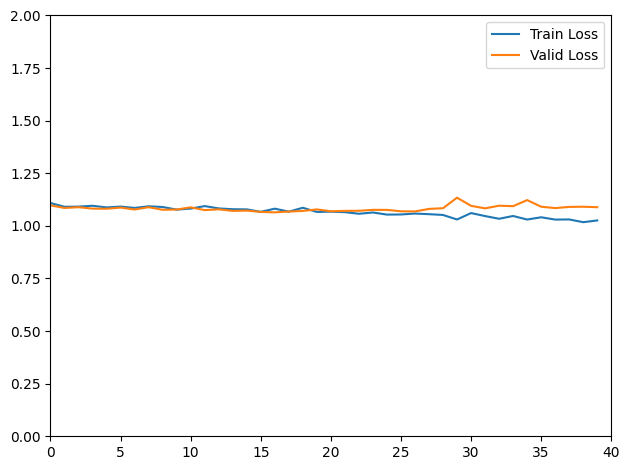

In [ ]:
from src.dataset._dataset_utils import print_target_distribution
from training_tools import plot_results

print_target_distribution([("Test", test_pred_dist)])

plot_results(train_losses, valid_losses, EPOCHS)
